In [ ]:
'''
@author - Rahul Nair
'''
!pip install gerrychain
!pip install geopandas
!git clone https://github.com/mggg/GerryChain.git

fatal: destination path 'GerryChain' already exists and is not an empty directory.


In [ ]:
path_to_pa = 'GerryChain/docs/user/PA_VTDs.json'

In [ ]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from math import radians, sin, cos, sqrt, asin
import json
import pandas as pd
import geopandas as gpd
from shapely.ops import cascaded_union
import math
from scipy.spatial import ConvexHull

with open(path_to_pa) as f:
    data = json.load(f)

In [ ]:
vtd_df = pd.DataFrame(data['nodes'])
vtd_df

,boundary_node,boundary_perim,area,STATEFP10,COUNTYFP10,VTDST10,GEOID10,VTDI10,NAME10,NAMELSAD10,LSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,NH_2MORE,HISP,H_WHITE,H_BLACK,H_AMIN,H_ASIAN,H_NHPI,H_OTHER,H_2MORE,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,ATG12D,ATG12R,F2014GOVD,F2014GOVR,GOV10D,GOV10R,PRES12D,PRES12O,PRES12R,SEN10D,SEN10R,T16ATGD,T16ATGR,T16PRESD,T16PRESOTH,T16PRESR,T16SEND,T16SENR,USS12D,USS12R,REMEDIAL,GOV,TS,CD_2011,SEND,HDIST,538DEM,538GOP,538CMPCT,id
0,True,0.063126,0.004278,42,085,960,42085960,A,SHENANGO TWP VTD WEST,SHENANGO TWP VTD WEST,00,G5240,N,39740056,141805,+41.1564874,-080.4865792,1915,1839,35,1,8,0,3,19,10,3,0,1,0,0,4,2,1553,7,1494,30,1,6,0,2,13,514.000104,388.000078,290.000058,242.000049,289.000058,349.000070,492.000099,11.000002,451.000091,315.000063,328.000066,416.000084,558.000112,342.000069,32.000006,631.000127,379.000076,590.000119,505.000102,423.000085,16,3,3,3,50,7,03,03,03,0
1,False,NaN,0.000551,42,039,40,4203940,A,BLOOMING VALLEY Voting District,BLOOMING VALLEY Voting District,00,G5240,N,5034196,57763,+41.6745788,-080.0382865,337,334,1,0,0,0,0,1,1,1,0,0,0,0,0,0,257,1,254,1,0,0,0,0,1,56.999999,123.999997,44.999999,96.999998,27.999999,124.999997,50.999999,10.000000,126.999997,34.999999,115.999998,39.999999,130.999997,32.999999,8.000000,133.999997,35.999999,125.999997,44.999999,135.999997,16,3,5,3,50,6,03,03,03,1
2,False,NaN,0.007934,42,039,10,4203910,A,ATHENS TWP Voting District,ATHENS TWP Voting District,00,G5240,N,73207387,91606,+41.7499682,-079.8467004,734,719,4,4,0,0,0,2,5,5,0,0,0,0,0,0,586,3,578,1,3,0,0,0,1,67.999996,214.999986,47.999997,155.999990,41.999997,200.999987,74.999995,6.000000,224.999985,51.999997,192.999987,52.999997,266.999983,49.999997,8.999999,273.999982,54.999996,260.999983,64.999996,229.999985,16,3,5,3,50,65,03,03,03,2
3,True,0.091923,0.010283,42,039,20,4203920,A,BEAVER TWP Voting District,BEAVER TWP Voting District,00,G5240,N,94916802,2059,+41.8099591,-080.4562835,902,881,7,0,0,0,0,11,3,2,0,0,0,0,1,0,656,0,645,4,0,0,0,0,7,111.000001,153.000001,66.000000,102.000000,66.000000,139.000001,110.000001,6.000000,167.000001,76.000000,134.000001,89.000000,203.000001,74.000000,13.000000,214.000001,75.000000,204.000001,112.000001,160.000001,16,3,3,3,50,17,03,03,03,3
4,False,NaN,0.010732,42,039,30,4203930,A,BLOOMFIELD TWP Voting District,BLOOMFIELD TWP Voting District,00,G5240,N,98195373,847815,+41.8113731,-079.8363351,1919,1877,7,1,2,1,0,16,15,10,0,0,0,0,1,4,1470,7,1450,2,1,2,0,0,8,329.999982,341.999981,225.999988,230.999987,177.999990,363.999980,314.999983,15.999999,393.999979,196.999989,339.999982,263.999986,528.999971,227.999988,29.999998,555.999970,246.999987,511.999972,267.999985,435.999976,16,3,5,3,50,65,03,03,03,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9250,False,NaN,0.002479,42,001,100,42001100,A,CONEWAGO TWP VTD 02,CONEWAGO TWP VTD 02,00,G5240,N,23415287,157872,+39.7934562,-077.0339760,4276,4042,51,4,49,0,5,47,78,41,0,0,4,0,31,2,3096,40,2971,35,0,30,0,1,19,676.791329,945.105052,437.511555,675.790159,308.360546,936.094516,550.643833,27.031606,1108.295860,358.419077,876.024280,467.546673,1074.256060,415.485801,65.076089,1098.284154,435.509213,1064.244354,589.689487,1052.230306,13,4,4,4,33,91,09,04,04,9250
9251,True,0.044005,0.004784,42,001,480,42001480,A,UNION TWP,UNION TWP Voting District,V2,G5240,N,45438462,82892,+39.7558798,-077.0498477,3148,2996,20,4,23,0,2,36,67,57,0,0,0,0,6,4,2404,34,2320,11,4,15,0,1,19,440.999993,855.999987,246.999996,588.999991,185.999997,832.999988,351.999995,24.000000,982.999985,217.999997,796.999988,347.999995,1122.999983,310.999995,62.999999,1154.999983,339.999995,1080.999984,364.999995,964.999986,

In [ ]:
'''
The following dataset is also similar. It's just that it has geometry data as well
which is important for k-means.
'''
df_2012 = gpd.read_file('/content/tl_2012_42_vtd10.shp')
df_2012

,ALAND10,AWATER10,CD12_DEM,CD12_REP,CD_2000,CD_2010,CD_BD,CD_FV,CD_FV2,CD_FVH,CD_NOW,CD_SM,COUNTYFP10,COUNTY_NAM,CTYFP_FUL,FUNCSTAT10,GEOID10,INTPTLAT10,INTPTLON10,LSAD10,MTFCC10,NAME10,NAMELSAD10,POPULATION,POP_ASIAN,POP_BLACK,POP_HAWAII,POP_HISPAN,POP_INDIAN,POP_MULTI,POP_OTHER,POP_TOTAL,POP_WHITE,PRES04_DEM,PRES04_REP,PRES08_DEM,PRES08_REP,PRES12_D50,PRES12_DEM,PRES12_R50,PRES12_REP,SLDL_BD,SLDL_NOW,SLDU_BD,SLDU_NOW,STATEFP10,VAP_ASIAN,VAP_BLACK,VAP_HAWAII,VAP_HISPAN,VAP_INDIAN,VAP_MULTI,VAP_OTHER,VAP_TOT,VAP_TOTAL,VAP_WHITE,VTDI10,VTDNAME,VTDST10,geometry
0,39740056,141805,405.401156,391.888878,3,2,1,2,2,2,3,2,85,Mercer County,42085,N,42085960,41.156487,-80.486579,00,G5240,SHENANGO TWP VTD WEST,SHENANGO TWP VTD WEST,1915.0,8.0,35.0,0.0,10.0,1.0,19.0,3.0,1915.0,1839.0,518.977396,454.611293,552.000000,459.000000,487.317556,506.458067,466.255074,447.941841,17,6,32,49,42,6.0,30.0,0.0,7.0,1.0,13.0,2.0,1500.782206,1553.0,1494.0,A,SHENANGO TWP VTD WEST,960,"POLYGON ((-80.51922 41.18555, -80.51905 41.185..."
1,5034196,57763,49.476528,76.625596,2,2,1,2,2,2,2,2,39,Crawford County,42039,N,4203940,41.674579,-80.038286,00,G5240,BLOOMING VALLEY Voting District,BLOOMING VALLEY Voting District,337.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,337.0,334.0,62.983194,130.202169,66.000000,123.000000,52.541669,54.605364,128.960295,123.895084,191,5,1,49,42,0.0,1.0,0.0,1.0,0.0,1.0,0.0,261.407064,257.0,254.0,A,BLOOMING VALLEY Voting District,40,"POLYGON ((-80.05844 41.68391, -80.05597 41.684..."
2,73207387,91606,107.761933,166.893731,2,2,1,2,2,2,2,2,39,Crawford County,42039,N,4203910,41.749968,-79.846700,00,G5240,ATHENS TWP Voting District,ATHENS TWP Voting District,734.0,0.0,4.0,0.0,5.0,4.0,2.0,0.0,734.0,719.0,86.840465,258.287229,91.000000,244.000000,72.443817,75.289213,255.823674,245.775614,108,5,13,49,42,0.0,1.0,0.0,3.0,3.0,1.0,0.0,569.355444,586.0,578.0,A,ATHENS TWP Voting District,10,"POLYGON ((-79.90979 41.77394, -79.90930 41.773..."
3,94916802,2059,132.426790,205.092841,2,2,1,2,2,2,2,2,39,Crawford County,42039,N,4203920,41.809959,-80.456283,00,G5240,BEAVER TWP Voting District,BEAVER TWP Voting District,902.0,0.0,7.0,0.0,3.0,0.0,11.0,0.0,902.0,881.0,7.192998,32.893394,8.903569,30.820046,7.460775,7.753814,32.640654,31.358618,36,4,1,49,42,0.0,4.0,0.0,0.0,0.0,7.0,0.0,699.671132,656.0,645.0,A,BEAVER TWP Voting District,20,"POLYGON ((-80.51935 41.84956, -80.51544 41.849..."
4,98195373,847815,281.737261,436.333882,2,2,1,2,2,2,2,2,39,Crawford County,42039,N,4203930,41.811373,-79.836335,00,G5240,BLOOMFIELD TWP Voting District,BLOOMFIELD TWP Voting District,1919.0,2.0,7.0,1.0,15.0,1.0,16.0,0.0,1919.0,1877.0,221.501142,296.918507,232.110733,280.494378,184.780081,192.037741,294.086485,282.535566,108,5,13,49,42,2.0,2.0,0.0,7.0,1.0,8.0,0.0,1488.546454,1470.0,1450.0,A,BLOOMFIELD TWP Voting District,30,"POLYGON ((-79.90998 41.85069, -79.90995 41.850..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9251,23415287,157872,509.831225,1154.353920,18,3,9,4,4,4,18,10,1,Adams County,42001,N,42001100,39.793456,-77.033976,00,G5240,CONEWAGO TWP VTD 02,CONEWAGO TWP VTD 02,4271.0,49.0,51.0,0.0,78.0,4.0,47.0,5.0,4271.0,4037.0,496.450065,1099.905955,636.000000,1026.000000,523.742108,544.313276,1084.887894,1042.276443,47,90,24,32,42,30.0,35.0,0.0,40.0,0.0,19.0,1.0,3325.969598,3091.0,2966.0,A,CONEWAGO TWP VTD 02,100,"POLYGON ((-77.05717 39.79550, -77.05703 39.795..."
9252,45438462,82892,375.778201,850.832625,18,3,9,4,4,4,18,10,1,Adams County,42001,N,42001480,39.755880,-77.049848,V2,G5240,UNION TWP,UNION TWP Voting District,3148.0,23.0,20.0,0.0,67.0,4.0,36.0,2.0,3148.0,2996.0,15.430624,57.044049,19.100189,53.448427,16.005066,16.633702,56.605745,54.382425,47,90,24,32,42,15.0,11.0,0.0,34.0,4.0,19.0,1.0,2451.452188,2404.0,2320.0,A,UNION TWP Voting District,480,"POLYGON ((-77.09981 39.77543, -77.0

In [ ]:
# calculating centroids
def centroid(points):
     x = [i for i,j in points] 
     y = [j for i,j in points]
     l = len(points)
     x_c = sum(x)/l
     y_c= sum(y)/l
     return (x_c, y_c)


def add_centroid(df):
  try:
    points = list(zip(*df.geometry.exterior.coords.xy))
  except AttributeError:
    points = list(point for polygon in df.geometry for point in polygon.exterior.coords[:-1])
  return centroid(points)

In [ ]:
df_2012['centroid'] = df_2012.apply(lambda x: add_centroid(x), axis=1)
df_2012['x_cent'] = pd.Series([q[0] for q in df_2012['centroid']])
df_2012['y_cent'] = pd.Series([q[1] for q in df_2012['centroid']])

In [ ]:
df_2012

,ALAND10,AWATER10,CD12_DEM,CD12_REP,CD_2000,CD_2010,CD_BD,CD_FV,CD_FV2,CD_FVH,CD_NOW,CD_SM,COUNTYFP10,COUNTY_NAM,CTYFP_FUL,FUNCSTAT10,GEOID10,INTPTLAT10,INTPTLON10,LSAD10,MTFCC10,NAME10,NAMELSAD10,POPULATION,POP_ASIAN,POP_BLACK,POP_HAWAII,POP_HISPAN,POP_INDIAN,POP_MULTI,POP_OTHER,POP_TOTAL,POP_WHITE,PRES04_DEM,PRES04_REP,PRES08_DEM,PRES08_REP,PRES12_D50,PRES12_DEM,PRES12_R50,PRES12_REP,SLDL_BD,SLDL_NOW,SLDU_BD,SLDU_NOW,STATEFP10,VAP_ASIAN,VAP_BLACK,VAP_HAWAII,VAP_HISPAN,VAP_INDIAN,VAP_MULTI,VAP_OTHER,VAP_TOT,VAP_TOTAL,VAP_WHITE,VTDI10,VTDNAME,VTDST10,geometry,centroid,x_cent,y_cent
0,39740056,141805,405.401156,391.888878,3,2,1,2,2,2,3,2,85,Mercer County,42085,N,42085960,41.156487,-80.486579,00,G5240,SHENANGO TWP VTD WEST,SHENANGO TWP VTD WEST,1915.0,8.0,35.0,0.0,10.0,1.0,19.0,3.0,1915.0,1839.0,518.977396,454.611293,552.000000,459.000000,487.317556,506.458067,466.255074,447.941841,17,6,32,49,42,6.0,30.0,0.0,7.0,1.0,13.0,2.0,1500.782206,1553.0,1494.0,A,SHENANGO TWP VTD WEST,960,"POLYGON ((-80.51922 41.18555, -80.51905 41.185...","(-80.48140895327104, 41.17013458878501)",-80.481409,41.170135
1,5034196,57763,49.476528,76.625596,2,2,1,2,2,2,2,2,39,Crawford County,42039,N,4203940,41.674579,-80.038286,00,G5240,BLOOMING VALLEY Voting District,BLOOMING VALLEY Voting District,337.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,337.0,334.0,62.983194,130.202169,66.000000,123.000000,52.541669,54.605364,128.960295,123.895084,191,5,1,49,42,0.0,1.0,0.0,1.0,0.0,1.0,0.0,261.407064,257.0,254.0,A,BLOOMING VALLEY Voting District,40,"POLYGON ((-80.05844 41.68391, -80.05597 41.684...","(-80.04136883823527, 41.67979917647059)",-80.041369,41.679799
2,73207387,91606,107.761933,166.893731,2,2,1,2,2,2,2,2,39,Crawford County,42039,N,4203910,41.749968,-79.846700,00,G5240,ATHENS TWP Voting District,ATHENS TWP Voting District,734.0,0.0,4.0,0.0,5.0,4.0,2.0,0.0,734.0,719.0,86.840465,258.287229,91.000000,244.000000,72.443817,75.289213,255.823674,245.775614,108,5,13,49,42,0.0,1.0,0.0,3.0,3.0,1.0,0.0,569.355444,586.0,578.0,A,ATHENS TWP Voting District,10,"POLYGON ((-79.90979 41.77394, -79.90930 41.773...","(-79.87392436363638, 41.75220520202022)",-79.873924,41.752205
3,94916802,2059,132.426790,205.092841,2,2,1,2,2,2,2,2,39,Crawford County,42039,N,4203920,41.809959,-80.456283,00,G5240,BEAVER TWP Voting District,BEAVER TWP Voting District,902.0,0.0,7.0,0.0,3.0,0.0,11.0,0.0,902.0,881.0,7.192998,32.893394,8.903569,30.820046,7.460775,7.753814,32.640654,31.358618,36,4,1,49,42,0.0,4.0,0.0,0.0,0.0,7.0,0.0,699.671132,656.0,645.0,A,BEAVER TWP Voting District,20,"POLYGON ((-80.51935 41.84956, -80.51544 41.849...","(-80.4612074042553, 41.81403081276593)",-80.461207,41.814031
4,98195373,847815,281.737261,436.333882,2,2,1,2,2,2,2,2,39,Crawford County,42039,N,4203930,41.811373,-79.836335,00,G5240,BLOOMFIELD TWP Voting District,BLOOMFIELD TWP Voting District,1919.0,2.0,7.0,1.0,15.0,1.0,16.0,0.0,1919.0,1877.0,221.501142,296.918507,232.110733,280.494378,184.780081,192.037741,294.086485,282.535566,108,5,13,49,42,2.0,2.0,0.0,7.0,1.0,8.0,0.0,1488.546454,1470.0,1450.0,A,BLOOMFIELD TWP Voting District,30,"POLYGON ((-79.90998 41.85069, -79.90995 41.850...","(-79.85604911504419, 41.81026712684365)",-79.856049,41.810267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9251,23415287,157872,509.831225,1154.353920,18,3,9,4,4,4,18,10,1,Adams County,42001,N,42001100,39.793456,-77.033976,00,G5240,CONEWAGO TWP VTD 02,CONEWAGO TWP VTD 02,4271.0,49.0,51.0,0.0,78.0,4.0,47.0,5.0,4271.0,4037.0,496.450065,1099.905955,636.000000,1026.000000,523.742108,544.313276,1084.887894,1042.276443,47,90,24,32,42,30.0,35.0,0.0,40.0,0.0,19.0,1.0,3325.969598,3091.0,2966.0,A,CONEWAGO TWP VTD 02,100,"POLYGON ((-77.05717 39.79550, -77.05703 39.795...","(-77.03341130489078, 39.79865343184184)",-77.033411,39.798653
9252,45438462,82892,3

### First of all, let's see how the classic k-means works for our case when population is not passed as a criteria.

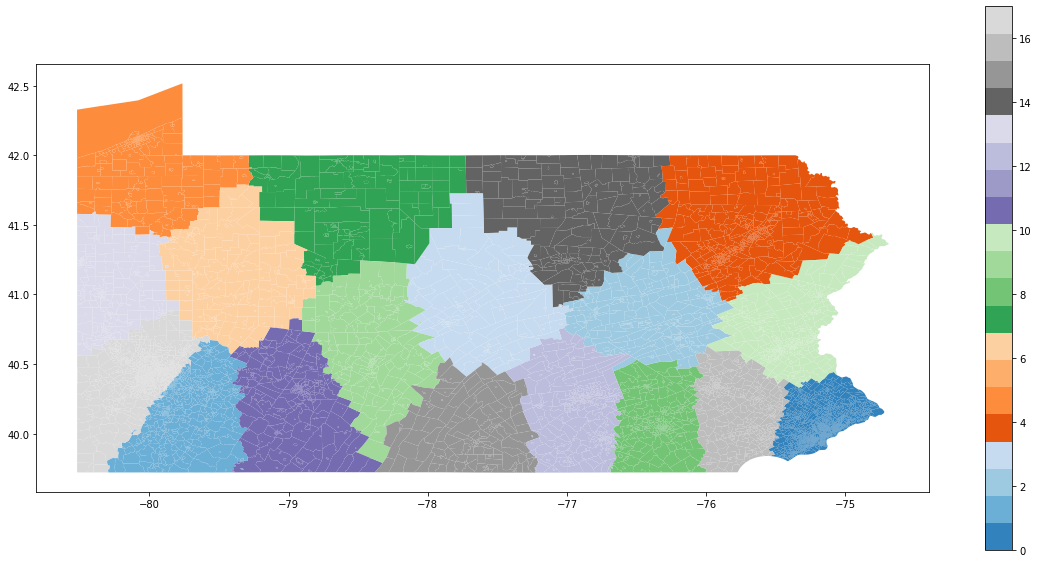

In [ ]:
df_new = df_2012[['x_cent', 'y_cent']]
kmeans = KMeans(init='k-means++', n_clusters=18, n_init=10, max_iter=300, random_state=7 )
model = kmeans.fit(df_new)
df_2012['district'] = pd.Series(kmeans.labels_)
df_2012.plot(column='district',cmap='tab20c', figsize=(20,10), legend=True)

### It's clearly visible that the resulting districts have comaparatively better shaped districts than the 2012 and 2018 plan. But it's important to find out whether the population distribution has improved or not.

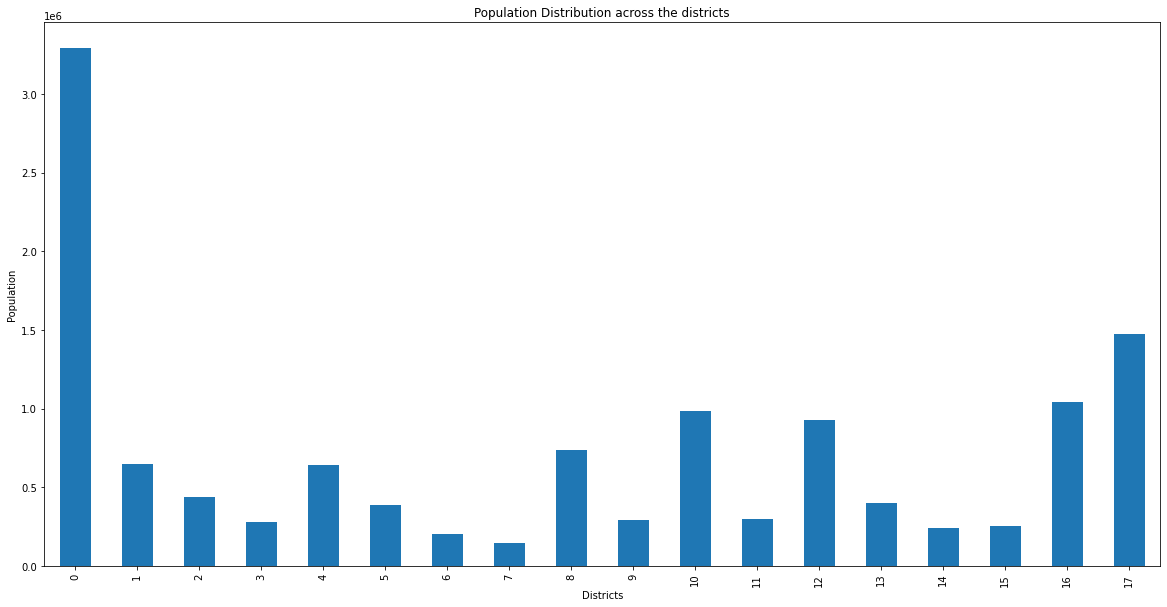

In [ ]:
pop_dis = df_2012.groupby('district').sum().reset_index()['POPULATION']
pop_dis.plot(kind='bar', xlabel='Districts', ylabel='Population', title='Population Distribution across the districts', figsize=(20,10))
plt.show()

### The population distribution is pretty bad, so much so that the even 2012 plan seems better.

### We need to come up with a better approach where population is also taken as criteria which can help mitigate this issue.



---



#### There is an [interesting paper](https://link.springer.com/article/10.1007/s42001-019-00053-9) which discusses about this issue. The researchers in that paper came up with a new algorithm named "Weighted k-means" which takes population as weight to calculate the distance between two points. 






### But just like classic k-means, weighted k-means also requires distance metric. Three metrics were tested, namely Haversine, Euclidean and Great circle. Great circle performed the worst while Haversine and Euclidean gave somewhat similar results. I am going with Euclidean.

In [ ]:
def euclidean(a, b):
  return np.linalg.norm(np.asarray(a) - np.asarray(b))

In [ ]:
# Reference Paper:- https://link.springer.com/article/10.1007/s42001-019-00053-9
# source code:- https://github.com/oliviaguest/weighted_k_means/blob/master/wkmeans.py
class weighted_kmeans():
  def __init__(self, K, X=None, c=None, dist=euclidean, alpha=0, beta=0, max_runs=200, label='Clustering for PA', max_diff=0.001):
    self.K = K
    self.X = X
    N = len(self.X)
    self.x_cent = self.X[:, 0]
    self.y_cent = self.X[:, 1]
    self.clusters = None
    self.cluster_indices = np.asarray([None for i in self.X])

    # For scaling distances as a function of cluster size:
    # the power the cardinalities will be raised to;
    self.alpha = alpha

    # and to scale the distances between points and centroids, which is
    # initialised to 1/k for all clusters.
    self.scaling_factor = np.ones((self.K)) / self.K

    # The stickiness used within the time-averaging.
    self.beta = beta

    # How many counts are represented by a single data point:
    if c is None:
      self.counts_per_data_point = [1 for x in self.X]
    else:
      self.counts_per_data_point = c

    # Population in each cluster:
    self.counts_per_cluster = [0 for x in range(self.K)]

    # Use max_runs to stop running forever in cases of non-convergence:
    self.max_runs = max_runs
    self.runs = 0
    self.dist = dist
    self.max_diff = max_diff
    # A label, to print out while running k-means, e.g., to distinguish a
    # specific instance of k-means, etc:
    self.label = label


  def _cluster_points(self):
    """Cluster the points."""
    # Initialise the values for the clusters and their counts
    clusters = [[] for i in range(self.K)]
    counts_per_cluster = [0 for i in range(self.K)]

    # Firstly perform classical k-means, weighting the distances.
    for index, x in enumerate(self.X):
      # For each data point x, find the minimum weighted distance to
      # cluster i from point x.
      bestmukey = min([(i[0],
                            self.scaling_factor[i[0]] *
                            self.dist(x, self.mu[i[0]]))
                            for i in enumerate(self.mu)],
                          key=lambda t: t[1])[0]
      # Add the data point x to the cluster it is closest to.
      clusters[bestmukey].append(x)
      counts_per_cluster[bestmukey] += self.counts_per_data_point[index]
      self.cluster_indices[index] = bestmukey

    # Update the clusters.
    self.clusters = clusters
    self.counts_per_cluster = counts_per_cluster

    # Secondly, calculate the scaling factor for each cluster.
    # Now that we have clusters to work with (at initialisation we don't),
    # we can calculate the scaling_factor per cluster. This calculates the
    # cardinality of the cluster raised to the power alpha, so it is purely
    # a function of the number of items in each cluster and the value of
    # alpha.
    scaling_factor = np.asarray([self.counts_per_cluster[index]**self.alpha
                                     for index, cluster in
                                     enumerate(self.clusters)])
    
    # Now we have all the numerators, divide them by their sum. This is
    # also known as the Luce choice share.
    scaling_factor = scaling_factor / np.sum(scaling_factor)

    # The scaling factors should sum to one here.
    # print 'Sum of luce choice shares:', np.around(np.sum(scaling_factor))
    # assert np.around(np.sum(scaling_factor)) == 1

    # Now we want to employ time-averaging on the scaling factor.
    scaling_factor = (1 - self.beta) * scaling_factor +\
                         (self.beta) * self.scaling_factor

    # Update the scaling factors for the next time step.
    self.scaling_factor = scaling_factor


  def _dist_from_centers(self):
    """Calculate the distance of each point to the closest centroids."""
    cent = self.mu
    X = self.X
    D2 = np.array([min([self.dist(x, c)**2 for c in cent]) for x in X])
    self.D2 = D2


  def _choose_next_center(self):
    """Select the next center probabilistically."""
    self.probs = self.D2 / self.D2.sum()
    self.cumprobs = self.probs.cumsum()
    r = random.random()
    ind = np.where(self.cumprobs >= r)[0][0]
    return(self.X[ind])

        
  def _reevaluate_centers(self):
    """Update the controids (aka mu) per cluster."""
    new_mu = []
    for k in self.clusters:
      new_mu.append(np.mean(k, axis=0))
    self.mu = new_mu


  def _has_converged(self):
    """Check if the items in clusters have stabilised between two runs.
    This checks to see if the distance between the centroids is lower than
    a fixed constant.
    """
    diff = 1000
    if self.clusters:
      for clu in self.clusters:
        # For each clusters, check the length. If zero, we have a
        # problem, we have lost clusters.
        if len(clu) is 0:
          raise ValueError('One or more clusters disappeared because'
                                     ' all points rushed away to other'
                                     ' cluster(s). Try increasing the'
                                     ' stickiness parameter (beta).')
        # Calculate the mean distance between previous and current
        # centroids.
      diff = 0
      for i in range(self.K):
        diff += self.dist(self.mu[i].tolist(), self.old_mu[i].tolist())
      diff /= self.K
    return diff < self.max_diff


  def find_centers(self, method='random'):
    """Find the centroids per cluster until equilibrium."""
    self.method = method
    X = self.X
    K = self.K
    # Previous centroids set to random values.
    self.old_mu = random.sample(list(X), K)

    if method == 'random':
    # If method of initialisation is not k++, use random centeroids.
      self.mu = random.sample(X, K)

    while not self._has_converged() and self.runs < self.max_runs:
        # While the algorithm has neither converged nor been run too many
        # times:
        # a) keep track of old centroids;
        self.old_mu = self.mu
        # b) assign all points in X to clusters;
        self._cluster_points()
        # c) recalculate the centers per cluster.
        self._reevaluate_centers()
        self.runs += 1
    print('\tLabel: '+ self.label)
    print('\tTotal runs:', self.runs)


  def init_centers(self):
    """Initialise the centers."""
    self.mu = random.sample(list(self.X), 1)
    while len(self.mu) < self.K:
      self._dist_from_centers()
      self.mu.append(self._choose_next_center())

In [ ]:
# max_population = vtd_df.groupby(['REMEDIAL']).sum().max()['TOTPOP']
# min_population = vtd_df.groupby(['REMEDIAL'])[['TOTPOP']].sum().min()['TOTPOP']

I tried using maximum population and minimum population from the 2018 plan but the algorithm was not converging. So with some trial and error, I set the max and min population as below.

In [ ]:
max_population = 850000
min_population = 600000

#### Although the range is still significant, the distribution will not be varying much overall.

In [ ]:
def cluster_population_is_out_of_bounds(people_per_cluster):
  # checks whether the cluster population is out of bounds or not.
  if np.max(people_per_cluster) > max_population:
    print('max: ', np.max(people_per_cluster))
    print("pop out of bounds")
    return True
  elif np.min(people_per_cluster) < min_population:
    print('min: ', np.min(people_per_cluster))
    print("pop out of bounds")
    return True
  print("pop not out of bounds")
  return False


def cluster():
  #Run clustering until a stable solution is found.
  X = np.stack((np.asarray(df_2012['x_cent'].apply(float)), 
                np.asarray(df_2012['y_cent'].apply(float))), axis=1)
  counts = list(df_2012['POP_TOTAL'].apply(float))
  people_per_cluster = 0
  alpha = 0.5
  beta = 0.5
  while cluster_population_is_out_of_bounds(people_per_cluster):
    kmeans = weighted_kmeans(K=18, X=X, c=counts, alpha=alpha, beta=beta)
    kmeans.init_centers()
    try:
      kmeans.find_centers(method='++')
    except ValueError:
      print('Cluster(s) cannot be empty!')
      kmeans = None
    if kmeans is None or alpha > 5.0:
      beta += 0.1
      if beta >= 1.0:
        print("\n breaking from the loop since proper clusters couldn't be formed")
        break
      alpha = 0.1
      people_per_cluster = [0]*18
      mu = np.sum(people_per_cluster)/18
      mu_list = [mu]*18
      s_d = np.sum((np.array(people_per_cluster) - np.array(mu_list))**2)
    else:
      # If it has returned a viable kmeans object.
      people_per_cluster = kmeans.counts_per_cluster
      mu = np.sum(people_per_cluster)/18
      mu_list = [mu]*18
      s_d = np.sum((np.array(people_per_cluster) - np.array(mu_list))**2)
      alpha += 0.5
    print('\n Alpha: ', alpha)
    print('\n Beta: ', beta)
    print('\n people per cluster: ', people_per_cluster)
    print('\n Deviation: ', s_d)

  df_2012['Cluster'] = kmeans.cluster_indices

In [ ]:
cluster()

min:  0
pop out of bounds
	Label: Clustering for PA
	Total runs: 58

 Alpha:  1.0

 Beta:  0.5

 people per cluster:  [783519.0, 948946.0, 1503819.0, 888114.0, 508420.0, 1616992.0, 421984.0, 658219.0, 448220.0, 744228.0, 422531.0, 332480.0, 452601.0, 447545.0, 962570.0, 709915.0, 501251.0, 351025.0]

 Deviation:  2339169966123.611
max:  1616992.0
pop out of bounds
	Label: Clustering for PA
	Total runs: 30

 Alpha:  1.5

 Beta:  0.5

 people per cluster:  [537101.0, 611893.0, 1150872.0, 548786.0, 454314.0, 894970.0, 937351.0, 478526.0, 514695.0, 1090123.0, 475670.0, 850879.0, 536060.0, 1305459.0, 852475.0, 529956.0, 374957.0, 558292.0]

 Deviation:  1294605940539.611
max:  1305459.0
pop out of bounds
	Label: Clustering for PA
	Total runs: 25

 Alpha:  2.0

 Beta:  0.5

 people per cluster:  [964469.0, 731912.0, 1053818.0, 837931.0, 511852.0, 698849.0, 669453.0, 885084.0, 557148.0, 571856.0, 542745.0, 457894.0, 919800.0, 772551.0, 736404.0, 549475.0, 532836.0, 708302.0]

 Deviation:  510

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cluster(s) cannot be empty!

 Alpha:  0.1

 Beta:  0.6

 people per cluster:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 Deviation:  0.0
min:  0
pop out of bounds
	Label: Clustering for PA
	Total runs: 31

 Alpha:  0.6

 Beta:  0.6

 people per cluster:  [587652.0, 941263.0, 479420.0, 1397638.0, 368461.0, 1083732.0, 417213.0, 344526.0, 629752.0, 867227.0, 265227.0, 443029.0, 695588.0, 1584244.0, 319897.0, 996247.0, 247181.0, 1034082.0]

 Deviation:  2687865158579.6113
max:  1584244.0
pop out of bounds
	Label: Clustering for PA
	Total runs: 31

 Alpha:  1.1

 Beta:  0.6

 people per cluster:  [958378.0, 734714.0, 452821.0, 585851.0, 1068223.0, 484253.0, 1138133.0, 319386.0, 545492.0, 460921.0, 859724.0, 656768.0, 514469.0, 1307667.0, 919744.0, 792158.0, 492502.0, 411175.0]

 Deviation:  1355820900315.611
max:  1307667.0
pop out of bounds
	Label: Clustering for PA
	Total runs: 42

 Alpha:  1.6

 Beta:  0.6

 people per cluster:  [943084.0, 847092.0, 426678.0, 856923.0, 8048

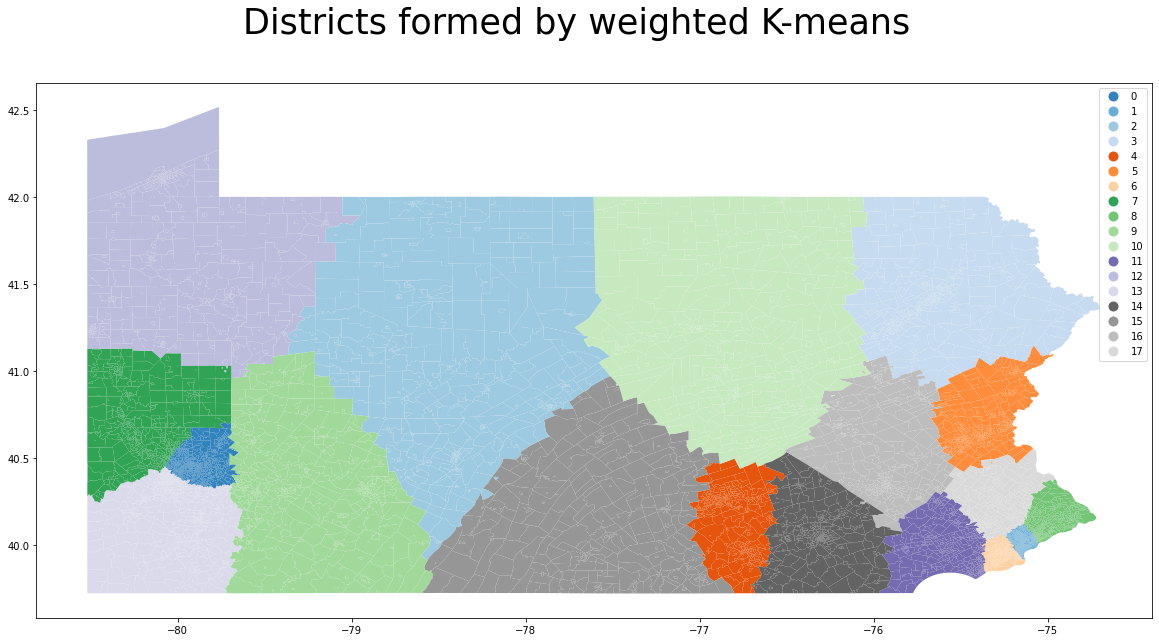

In [ ]:
fig = plt.figure(1, figsize=(20,10)) 
ax = fig.add_subplot()
fig.suptitle('Districts formed by weighted K-means', fontsize=35)
df_2012.plot(ax=ax, column='Cluster',cmap='tab20c', legend=True)
plt.show()

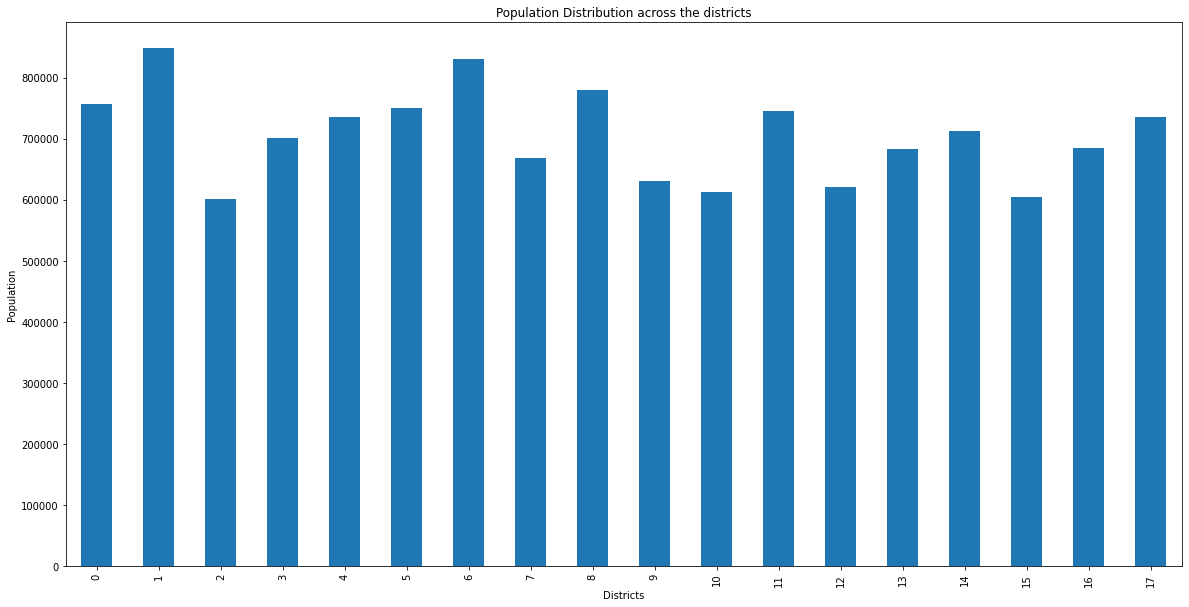

In [ ]:
pop_dis = df_2012.groupby('Cluster').sum().reset_index()['POPULATION']
pop_dis.plot(kind='bar', xlabel='Districts', ylabel='Population', title='Population Distribution across the districts', figsize=(20,10))
plt.show()

### As we can see, the cluster (districts) formed are pretty much compact and even the population distribution is impressive compared to the 2012, 2018 and the classic k-means plan.

So we can conclude that weighted k-means indeed gives us a better districting plan. But in order to confirm this, I would like to check the fairness metrics.

In [ ]:
k_means_vtd = pd.merge(vtd_df, df_2012[['GEOID10', 'Cluster']], how='left', on='GEOID10')

In [ ]:
district = k_means_vtd.groupby('CD_2011').sum().reset_index()

### Partisan-Bias

In [ ]:
# Partisan-bias for K-means plan
district = k_means_vtd.groupby('Cluster').sum().reset_index()
district['T16_REP_PCT'] = district['T16PRESR']/(district['T16PRESR']+district['T16PRESD'])
district['T16_DEM_PCT'] = district['T16PRESD']/(district['T16PRESR']+district['T16PRESD'])
total_rep_pct = district['T16_REP_PCT'].sum()
total_dem_pct = district['T16_DEM_PCT'].sum()
if (total_rep_pct>total_dem_pct):
  d_shift_fairness = (9-total_dem_pct)/18
else :
  d_shift_fairness = (9-total_rep_pct)/18
district['T16_NEW_DEM_PCT'] = district['T16_DEM_PCT']+d_shift_fairness
district['T16_NEW_REP_PCT'] = district['T16_REP_PCT']-d_shift_fairness
district.loc[district['T16_NEW_REP_PCT'] > 0.5 , 'REP'] = 1
district.loc[district['T16_NEW_REP_PCT'] == 0.5 , 'REP'] = 0.5
district.loc[district['T16_NEW_DEM_PCT'] > 0.5 , 'DEM'] = 1
district.loc[district['T16_NEW_DEM_PCT'] == 0.5 , 'DEM'] = 0.5
rep_win = district['REP'].sum()
dem_win = district['DEM'].sum()
partisan_bias_rep = (rep_win/18)-0.5
partisan_bias_dem = (dem_win/18)-0.5
print ("K-Means Plan")
if partisan_bias_rep >= 0:
  print ("Pro Republican")
  print ("partisan bias : " + str(partisan_bias_rep))
elif partisan_bias_dem >= 0:
  print ("Pro Democratic")
  print ("partisan bias : "+ str(partisan_bias_dem))['T16_REP_PCT'] = district['T16PRESR']/(district['T16PRESR']+district['T16PRESD'])

print(50*'-')

# Partisan Bias for 2012 plan (Code by Kapil Khond)
district = k_means_vtd.groupby('CD_2011').sum().reset_index()
district['T16_REP_PCT'] = district['T16PRESR']/(district['T16PRESR']+district['T16PRESD'])
district['T16_DEM_PCT'] = district['T16PRESD']/(district['T16PRESR']+district['T16PRESD'])
total_rep_pct = district['T16_REP_PCT'].sum()
total_dem_pct = district['T16_DEM_PCT'].sum()
if (total_rep_pct>total_dem_pct):
  d_shift_fairness = (9-total_dem_pct)/18
else :
  d_shift_fairness = (9-total_rep_pct)/18
district['T16_NEW_DEM_PCT'] = district['T16_DEM_PCT']+d_shift_fairness
district['T16_NEW_REP_PCT'] = district['T16_REP_PCT']-d_shift_fairness
district.loc[district['T16_NEW_REP_PCT'] > 0.5 , 'REP'] = 1
district.loc[district['T16_NEW_REP_PCT'] == 0.5 , 'REP'] = 0.5
district.loc[district['T16_NEW_DEM_PCT'] > 0.5 , 'DEM'] = 1
district.loc[district['T16_NEW_DEM_PCT'] == 0.5 , 'DEM'] = 0.5
rep_win = district['REP'].sum()
dem_win = district['DEM'].sum()
partisan_bias_rep = (rep_win/18)-0.5
partisan_bias_dem = (dem_win/18)-0.5
print ("2012 plan")
if partisan_bias_rep >= 0:
  print ("Pro Republican")
  print ("partisan bias : " + str(partisan_bias_rep))
elif partisan_bias_dem >= 0:
  print ("Pro Democratic")
  print ("partisan bias : "+ str(partisan_bias_dem))['T16_REP_PCT'] = district['T16PRESR']/(district['T16PRESR']+district['T16PRESD'])

K-Means Plan
Pro Republican
partisan bias : 0.11111111111111116
--------------------------------------------------
2012 plan
Pro Republican
partisan bias : 0.11111111111111116


### Efficiency Gap

In [ ]:
# Efficiency Gap for K-means plan
district = k_means_vtd.groupby('Cluster').sum().reset_index()
district['D_prop'] =  district["T16PRESD"]/(district["T16PRESD"]+district["T16PRESR"])
district['R_prop'] =  district["T16PRESR"]/(district["T16PRESD"]+district["T16PRESR"])
district['D_wasted'] = np.where(district['D_prop'] <  district['R_prop'], district['D_prop'], district['D_prop'] -.5)
district['R_wasted'] = np.where(district['R_prop'] <  district['D_prop'], district['R_prop'], district['R_prop'] -.5)
efficiency_gap = (sum(district["D_wasted"]) - sum(district["R_wasted"])) / (sum(district["R_prop"]) + sum(district["D_prop"]) )
print('Efficiency Gap for K-Means Plan (Pro-R)', efficiency_gap)

print(50*'-')

# Efficiency Gap for 2012 plan (Code by Victoria Belotti)
district = k_means_vtd.groupby('CD_2011').sum().reset_index()
district['D_prop'] =  district["T16PRESD"]/(district["T16PRESD"]+district["T16PRESR"])
district['R_prop'] =  district["T16PRESR"]/(district["T16PRESD"]+district["T16PRESR"])
district['D_wasted'] = np.where(district['D_prop'] <  district['R_prop'], district['D_prop'], district['D_prop'] -.5)
district['R_wasted'] = np.where(district['R_prop'] <  district['D_prop'], district['R_prop'], district['R_prop'] -.5)
efficiency_gap = (sum(district["D_wasted"]) - sum(district["R_wasted"])) / (sum(district["R_prop"]) + sum(district["D_prop"]) )
print('Efficiency Gap for 2012 Plan (Pro-R)', efficiency_gap)

Efficiency Gap for K-Means Plan (Pro-R) 0.058337630596914915
--------------------------------------------------
Efficiency Gap for 2012 Plan (Pro-R) 0.14873416638683068


### Mean-Median difference

In [ ]:
# Mean-Median difference for K-means plan
district = k_means_vtd.groupby('Cluster').sum().reset_index()
district['T16PRESTOT']=district['T16PRESR']+district['T16PRESD']
district['T16PRESR_PCT']=district['T16PRESR']/district['T16PRESTOT']
district['T16PRESD_PCT']=district['T16PRESD']/district['T16PRESTOT']
avg_repub_vote_share=district['T16PRESR_PCT'].mean()
median_repub_vote_share=district['T16PRESR_PCT'].median()
print('Mean-Median difference for K-Means plan (Pro-R)', median_repub_vote_share - avg_repub_vote_share)

print(50*'-')

# Mean-Median difference for 2012 plan (Code by Adika Jain)
district = k_means_vtd.groupby('CD_2011').sum().reset_index()
district['T16PRESTOT']=district['T16PRESR']+district['T16PRESD']
district['T16PRESR_PCT']=district['T16PRESR']/district['T16PRESTOT']
district['T16PRESD_PCT']=district['T16PRESD']/district['T16PRESTOT']
avg_repub_vote_share=district['T16PRESR_PCT'].mean()
median_repub_vote_share=district['T16PRESR_PCT'].median()
print('Mean-Median difference for 2012 plan (Pro-R)', median_repub_vote_share - avg_repub_vote_share)

Mean-Median differnce for K-Means plan (Pro-R) 0.03940135695793223
--------------------------------------------------
Mean-Median differnce for 2012 plan (Pro-R) 0.037523665174864496


### Compactness Metrics

In [ ]:
# Calculating area and perimeter of the newly formed districts
geometry = []
area = []
perimeter = []
for i in range(0,18):
  d = df_2012[df_2012.Cluster == i]
  boundary = gpd.GeoSeries(cascaded_union(d.geometry))
  geometry.append(boundary[0])
  area.append(boundary.area[0])
  perimeter.append(boundary.length[0])


In [ ]:
districts = gpd.GeoDataFrame()

In [ ]:
District = [i for i in range(0,18)]
districts['District'] = District

In [ ]:
districts['perimeter'] = perimeter
districts['area'] = area
districts['geometry'] = geometry

In [ ]:
districts

,District,perimeter,area,geometry
0,0,2.341244,0.104470,"POLYGON ((-79.67468 40.37614, -79.67461 40.376..."
1,1,0.884384,0.019976,"MULTIPOLYGON (((-75.14899 39.91871, -75.14889 ..."
2,2,8.747692,2.369473,"MULTIPOLYGON (((-78.60010 39.93900, -78.60005 ..."
3,3,5.920701,1.068451,"POLYGON ((-75.52710 40.97333, -75.52754 40.973..."
4,4,3.582662,0.280017,"MULTIPOLYGON (((-76.69713 39.75259, -76.69634 ..."
5,5,3.439104,0.277744,"MULTIPOLYGON (((-75.16663 40.56422, -75.16656 ..."
6,6,1.161116,0.034254,"POLYGON ((-75.36557 39.85069, -75.36557 39.850..."
7,7,3.823228,0.501750,"POLYGON ((-80.49339 40.28531, -80.49338 40.285..."
8,8,1.578081,0.082254,"POLYGON ((-75.03058 40.01619, -75.03094 40.016..."
9,9,6.339094,1.194456,"POLYGON ((-78.83765 39.72295, -78.83805 39.722..."


In [ ]:
# saving the district data for future use
districts.to_file('new_districts.shp')

In [ ]:
'''
Functions that I wrote in EDA.ipynb to calculate certain compactness metrics.
There are some minor changes as the 2012 and 2018 plan didn't have Multipolygon issues.
Those changes come for calculating area/convex hull and reock.
'''

# Calculating Polsby-Popper compactness metric
def polsby(df):
  return ((4*np.pi*df.area)/((df.perimeter)**2)) *100


# Calculating Schwartzberg compactness metric
def schwartz(df):
  return (1/(df.perimeter/(2*math.sqrt(np.pi*df.area))))*100


# Calculating area/convex hull compactness metric
def convex_hull_area(df):
  points = []
  if df.geometry.geom_type == 'Polygon':
    points = list(zip(*df.geometry.exterior.coords.xy))
    # hull = ConvexHull(points)
  else:
    for polygon in df.geometry:
      points.extend(polygon.exterior.coords[:-1])
  hull = ConvexHull(points)
  return hull.area


def area_by_convex_hull(df):
  return (df.area/df.convex_hull_area)*100

In [ ]:
# Referring code from https://www.nayuki.io/page/smallest-enclosing-circle
# This cell is used to calculate the area of minimum circle formed with the boundaries.

def make_circle(df):
	# Convert to float and randomize order
	points = []
	if df.geometry.geom_type == 'Polygon':
		points = list(zip(*df.geometry.exterior.coords.xy))
	else:
		for polygon in df.geometry:
			points.extend(polygon.exterior.coords[:-1])
	shuffled = [(float(x), float(y)) for (x, y) in points]
	random.shuffle(shuffled)
	
	# Progressively add points to circle or recompute circle
	c = None
	for (i, p) in enumerate(shuffled):
		if c is None or not is_in_circle(c, p):
			c = _make_circle_one_point(shuffled[ : i + 1], p)
	return c


# One boundary point known
def _make_circle_one_point(points, p):
  c = (p[0], p[1], 0.0)
  for (i, q) in enumerate(points):
    if not is_in_circle(c, q):
      if c[2] == 0.0:
        c = make_diameter(p, q)
      else:
        c = _make_circle_two_points(points[ : i + 1], p, q)
  return c


# Two boundary points known
def _make_circle_two_points(points, p, q):
	circ = make_diameter(p, q)
	left  = None
	right = None
	px, py = p
	qx, qy = q
	
	# For each point not in the two-point circle
	for r in points:
		if is_in_circle(circ, r):
			continue
		
		# Form a circumcircle and classify it on left or right side
		cross = _cross_product(px, py, qx, qy, r[0], r[1])
		c = make_circumcircle(p, q, r)
		if c is None:
			continue
		elif cross > 0.0 and (left is None or _cross_product(px, py, qx, qy, c[0], c[1]) > _cross_product(px, py, qx, qy, left[0], left[1])):
			left = c
		elif cross < 0.0 and (right is None or _cross_product(px, py, qx, qy, c[0], c[1]) < _cross_product(px, py, qx, qy, right[0], right[1])):
			right = c
	
	# Select which circle to return
	if left is None and right is None:
		return circ
	elif left is None:
		return right
	elif right is None:
		return left
	else:
		return left if (left[2] <= right[2]) else right


def make_diameter(a, b):
	cx = (a[0] + b[0]) / 2
	cy = (a[1] + b[1]) / 2
	r0 = math.hypot(cx - a[0], cy - a[1])
	r1 = math.hypot(cx - b[0], cy - b[1])
	return (cx, cy, max(r0, r1))


def make_circumcircle(a, b, c):
	# Mathematical algorithm from Wikipedia: Circumscribed circle
	ox = (min(a[0], b[0], c[0]) + max(a[0], b[0], c[0])) / 2
	oy = (min(a[1], b[1], c[1]) + max(a[1], b[1], c[1])) / 2
	ax = a[0] - ox;  ay = a[1] - oy
	bx = b[0] - ox;  by = b[1] - oy
	cx = c[0] - ox;  cy = c[1] - oy
	d = (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by)) * 2.0
	if d == 0.0:
		return None
	x = ox + ((ax*ax + ay*ay) * (by - cy) + (bx*bx + by*by) * (cy - ay) + (cx*cx + cy*cy) * (ay - by)) / d
	y = oy + ((ax*ax + ay*ay) * (cx - bx) + (bx*bx + by*by) * (ax - cx) + (cx*cx + cy*cy) * (bx - ax)) / d
	ra = math.hypot(x - a[0], y - a[1])
	rb = math.hypot(x - b[0], y - b[1])
	rc = math.hypot(x - c[0], y - c[1])
	return (x, y, max(ra, rb, rc))
 

_MULTIPLICATIVE_EPSILON = 1 + 1e-14


def is_in_circle(c, p):
	return c is not None and math.hypot(p[0] - c[0], p[1] - c[1]) <= c[2] * _MULTIPLICATIVE_EPSILON


# Returns twice the signed area of the triangle defined by (x0, y0), (x1, y1), (x2, y2).
def _cross_product(x0, y0, x1, y1, x2, y2):
	return (x1 - x0) * (y2 - y0) - (y1 - y0) * (x2 - x0)
 

# Calculate Area/Minimum_Bounded_Circle
def area_by_circle_area(df):
  return df.area/df.circle_area

In [ ]:
districts['polsby'] = districts.apply(lambda x: polsby(x), axis=1)
districts['schwartz'] = districts.apply(lambda x: schwartz(x), axis=1)
districts['convex_hull_area'] = districts.apply(lambda x: convex_hull_area(x), axis=1)
districts['area/convex_hull'] = districts.apply(lambda x: area_by_convex_hull(x), axis=1)
districts['circle'] = districts.apply(lambda x: make_circle(x), axis=1)
districts['circle_area'] = [k for i,j,k in districts.circle] 
districts['reock'] = districts.apply(lambda x: area_by_circle_area(x), axis=1)

In [ ]:
districts

,District,perimeter,area,geometry,polsby,schwartz,convex_hull_area,area/convex_hull,circle,circle_area,reock
0,0,2.341244,0.104470,"POLYGON ((-79.67468 40.37614, -79.67461 40.376...",23.950160,48.938901,1.324134,7.889692,"(-79.84426416993826, 40.51796559153622, 0.2419...",0.241919,0.431839
1,1,0.884384,0.019976,"MULTIPOLYGON (((-75.14899 39.91871, -75.14889 ...",32.094614,56.652109,0.583798,3.421692,"(-75.1480797161552, 40.01658861424027, 0.10360...",0.103604,0.192809
2,2,8.747692,2.369473,"MULTIPOLYGON (((-78.60010 39.93900, -78.60005 ...",38.911197,62.378840,6.373769,37.175380,"(-78.33116471851896, 41.065771023546986, 1.179...",1.179679,2.008574
3,3,5.920701,1.068451,"POLYGON ((-75.52710 40.97333, -75.52754 40.973...",38.301700,61.888367,4.152235,25.731937,"(-75.43726257173395, 41.54615173706779, 0.7699...",0.769961,1.387668
4,4,3.582662,0.280017,"MULTIPOLYGON (((-76.69713 39.75259, -76.69634 ...",27.414632,52.358984,2.177683,12.858480,"(-76.77577717032608, 40.10725182179062, 0.3965...",0.396578,0.706082
5,5,3.439104,0.277744,"MULTIPOLYGON (((-75.16663 40.56422, -75.16656 ...",29.509588,54.322728,2.292325,12.116239,"(-75.273369, 40.786666999999994, 0.43456744542...",0.434567,0.639126
6,6,1.161116,0.034254,"POLYGON ((-75.36557 39.85069, -75.36557 39.850...",31.927775,56.504668,0.756838,4.525927,"(-75.2610858936933, 39.93486837985015, 0.13503...",0.135031,0.253674
7,7,3.823228,0.501750,"POLYGON ((-80.49339 40.28531, -80.49338 40.285...",43.135731,65.677798,2.979700,16.838953,"(-80.14725566620235, 40.703363789740614, 0.562...",0.562207,0.892465
8,8,1.578081,0.082254,"POLYGON ((-75.03058 40.01619, -75.03094 40.016...",41.505722,64.424934,1.184927,6.941691,"(-74.93431658108247, 40.16890909843343, 0.2132...",0.213260,0.385699
9,9,6.339094,1.194456,"POLYGON ((-78.83765 39.72295, -78.83805 39.722...",37.353008,61.117107,4.499836,26.544426,"(-79.15558445941689, 40.33578792495412, 0.8339...",0.834000,1.432201


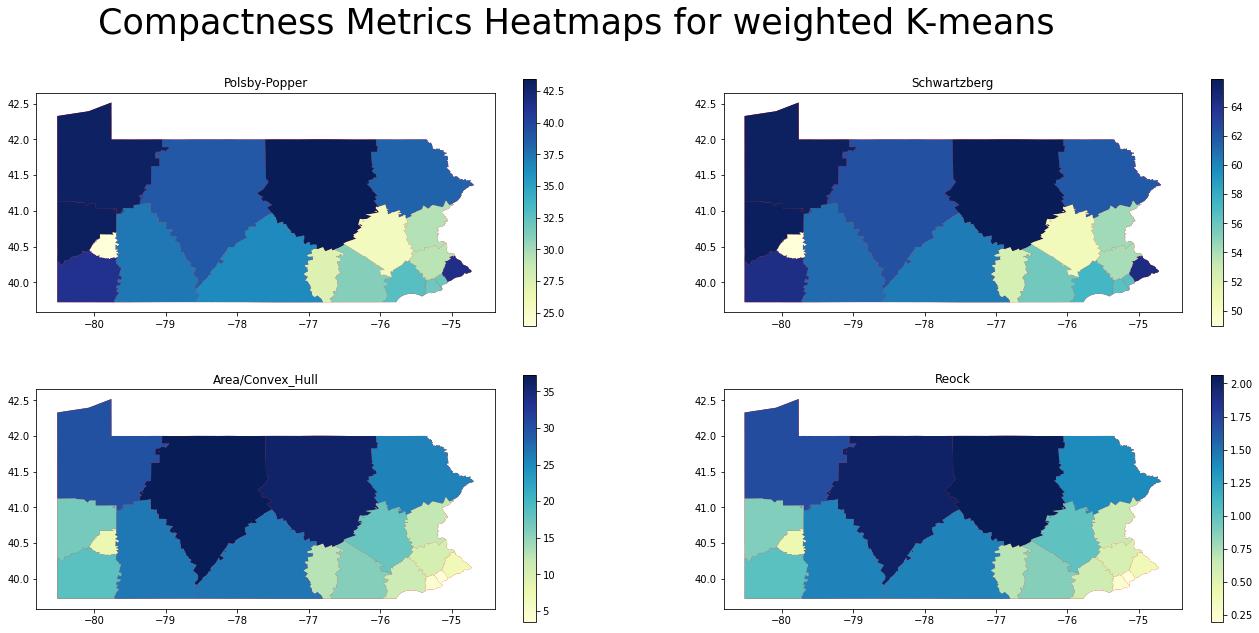

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
plt.subplots_adjust(right=1)
axs[0,0].set_title("Polsby-Popper")
axs[0,1].set_title("Schwartzberg")
axs[1,0].set_title("Area/Convex_Hull")
axs[1,1].set_title("Reock")
fig.suptitle('Compactness Metrics Heatmaps for weighted K-means', fontsize=35)
districts.plot(ax=axs[0,0], color='red', linewidth=5)
districts.plot(column='polsby',cmap='YlGnBu', legend=True, ax=axs[0,0])
districts.plot(ax=axs[0,1], color='red', linewidth=5)
districts.plot(column='schwartz',cmap='YlGnBu', legend=True, ax=axs[0,1])
districts.plot(ax=axs[1,0], color='red', linewidth=1)
districts.plot(column='area/convex_hull', cmap='YlGnBu', legend=True, ax=axs[1,0])
districts.plot(ax=axs[1,1], color='red', linewidth=1)
districts.plot(column='reock', cmap='YlGnBu', legend=True, ax=axs[1,1])
plt.show()

#### We see that the compactness score for this plan is way better than the 2012 plan, even better than the 2018 plan. 

#### In conclusion, although this plan is definitely better in terms of compactness scores, fairness metrics especially the partisan-bias and mean-median difference is a bit worse (not by a big margin though). But efficiency gap has shown a massive improvement. So, yes we can go with this plan when it is compared to 2012, and even to some extent 2018 plan, but it does need few more work as the voter distribution is still somewhere affected.

In [ ]:
districts = districts.drop('circle', axis=1)

In [ ]:
# saving the values of newly formed districts with their compactness scores
districts.to_file("weighted_K-means_districts.shp")

In [ ]:
districts

,District,perimeter,area,geometry,polsby,schwartz,convex_hull_area,area/convex_hull,circle_area,reock
0,0,2.341244,0.104470,"POLYGON ((-79.67468 40.37614, -79.67461 40.376...",23.950160,48.938901,1.324134,7.889692,0.241919,0.431839
1,1,0.884384,0.019976,"MULTIPOLYGON (((-75.14899 39.91871, -75.14889 ...",32.094614,56.652109,0.583798,3.421692,0.103604,0.192809
2,2,8.747692,2.369473,"MULTIPOLYGON (((-78.60010 39.93900, -78.60005 ...",38.911197,62.378840,6.373769,37.175380,1.179679,2.008574
3,3,5.920701,1.068451,"POLYGON ((-75.52710 40.97333, -75.52754 40.973...",38.301700,61.888367,4.152235,25.731937,0.769961,1.387668
4,4,3.582662,0.280017,"MULTIPOLYGON (((-76.69713 39.75259, -76.69634 ...",27.414632,52.358984,2.177683,12.858480,0.396578,0.706082
5,5,3.439104,0.277744,"MULTIPOLYGON (((-75.16663 40.56422, -75.16656 ...",29.509588,54.322728,2.292325,12.116239,0.434567,0.639126
6,6,1.161116,0.034254,"POLYGON ((-75.36557 39.85069, -75.36557 39.850...",31.927775,56.504668,0.756838,4.525927,0.135031,0.253674
7,7,3.823228,0.501750,"POLYGON ((-80.49339 40.28531, -80.49338 40.285...",43.135731,65.677798,2.979700,16.838953,0.562207,0.892465
8,8,1.578081,0.082254,"POLYGON ((-75.03058 40.01619, -75.03094 40.016...",41.505722,64.424934,1.184927,6.941691,0.213260,0.385699
9,9,6.339094,1.194456,"POLYGON ((-78.83765 39.72295, -78.83805 39.722...",37.353008,61.117107,4.499836,26.544426,0.834000,1.432201
